In [ ]:
pip install adabelief-pytorch

Files already downloaded and verified
Files already downloaded and verified

Training with Adam...
Epoch [1/10], Loss: 1.5355
Epoch [2/10], Loss: 1.1780
Epoch [3/10], Loss: 1.0162
Epoch [4/10], Loss: 0.9156
Epoch [5/10], Loss: 0.8405
Epoch [6/10], Loss: 0.7812
Epoch [7/10], Loss: 0.7334
Epoch [8/10], Loss: 0.6925
Epoch [9/10], Loss: 0.6584
Epoch [10/10], Loss: 0.6290
Test Accuracy: 76.81%
Loss Stability (Variance): 0.071515
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Reco

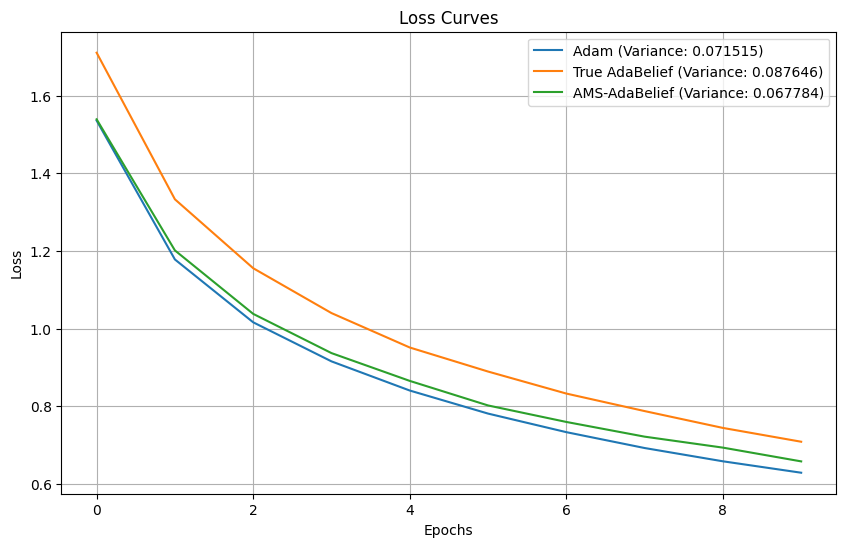

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from adabelief_pytorch import AdaBelief  # True AdaBelief optimizer
import numpy as np
import matplotlib.pyplot as plt

# AMS-AdaBelief Optimizer
class AMSAdaBelief(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-16, weight_decay=0, ams_params=(0.5, 1.0)):
        gamma_min, rho = ams_params
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma_min=gamma_min, rho=rho)
        super(AMSAdaBelief, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                gamma_t = min(1.0, max(group['gamma_min'], group['rho'] * torch.norm(exp_avg) / (torch.norm(exp_avg_sq.sqrt()) + group['eps'])))
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2

                step_size = group['lr'] / (corrected_exp_avg_sq.sqrt().add(group['eps']))
                p.data.add_(-gamma_t * step_size * corrected_exp_avg)
        return loss

# CIFAR-10 Dataset Preparation
def prepare_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader

# Simple ResNet18 Model
def get_model():
    return torchvision.models.resnet18(num_classes=10)

# Training Function
def train(model, optimizer, criterion, trainloader, epochs):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return train_losses

# Testing Function
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Experiment Runner
def run_experiment(optimizer_class, optimizer_name, trainloader, testloader):
    model = get_model().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters())
    print(f"\nTraining with {optimizer_name}...")
    train_losses = train(model, optimizer, criterion, trainloader, epochs=10)
    accuracy = test(model, testloader)
    # Calculate loss stability as variance of training losses
    loss_stability = np.var(train_losses)
    print(f"Loss Stability (Variance): {loss_stability:.6f}")
    return train_losses, accuracy, loss_stability

# Plot Loss Curve
def plot_loss_curves(results):
    plt.figure(figsize=(10, 6))
    for name, res in results.items():
        plt.plot(res["losses"], label=f"{name} (Variance: {res['loss_stability']:.6f})")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves.png")
    plt.show()

# Main Function
if __name__ == "__main__":
    trainloader, testloader = prepare_data()

    # Define optimizers
    optimizers = {
        "Adam": lambda params: optim.Adam(params, lr=1e-3),
        "True AdaBelief": lambda params: AdaBelief(
            params,
            lr=1e-3,
            betas=(0.9, 0.999),
            eps=1e-16,  # Recommended for image classification
            weight_decay=1e-4,
            rectify=True  # Enables rectification for better convergence
        ),
        "AMS-AdaBelief": lambda params: AMSAdaBelief(params, lr=1e-3, ams_params=(0.5, 1.0))
    }

    # Run experiments for each optimizer
    results = {}
    for name, opt_func in optimizers.items():
        train_losses, accuracy, loss_stability = run_experiment(opt_func, name, trainloader, testloader)
        results[name] = {"losses": train_losses, "accuracy": accuracy, "loss_stability": loss_stability}

    # Final Summary
    print("\nFinal Results:")
    for name, res in results.items():
        print(f"{name}: Final Test Accuracy = {res['accuracy']:.2f}%, Loss Stability (Variance) = {res['loss_stability']:.6f}")

    # Plot Loss Curves
    plot_loss_curves(results)

Files already downloaded and verified
Files already downloaded and verified

Training with Adam...
Epoch [1/50], Loss: 1.5427
Epoch [2/50], Loss: 1.1868
Epoch [3/50], Loss: 1.0243
Epoch [4/50], Loss: 0.9202
Epoch [5/50], Loss: 0.8423
Epoch [6/50], Loss: 0.7816
Epoch [7/50], Loss: 0.7440
Epoch [8/50], Loss: 0.6970
Epoch [9/50], Loss: 0.6679
Epoch [10/50], Loss: 0.6346
Epoch [11/50], Loss: 0.6081
Epoch [12/50], Loss: 0.5932
Epoch [13/50], Loss: 0.5682
Epoch [14/50], Loss: 0.5401
Epoch [15/50], Loss: 0.5232
Epoch [16/50], Loss: 0.5151
Epoch [17/50], Loss: 0.4910
Epoch [18/50], Loss: 0.4838
Epoch [19/50], Loss: 0.4684
Epoch [20/50], Loss: 0.4495
Epoch [21/50], Loss: 0.4387
Epoch [22/50], Loss: 0.4287
Epoch [23/50], Loss: 0.4173
Epoch [24/50], Loss: 0.4068
Epoch [25/50], Loss: 0.3962
Epoch [26/50], Loss: 0.3839
Epoch [27/50], Loss: 0.3711
Epoch [28/50], Loss: 0.3613
Epoch [29/50], Loss: 0.3524
Epoch [30/50], Loss: 0.3466
Epoch [31/50], Loss: 0.3366
Epoch [32/50], Loss: 0.3264
Epoch [33/50],

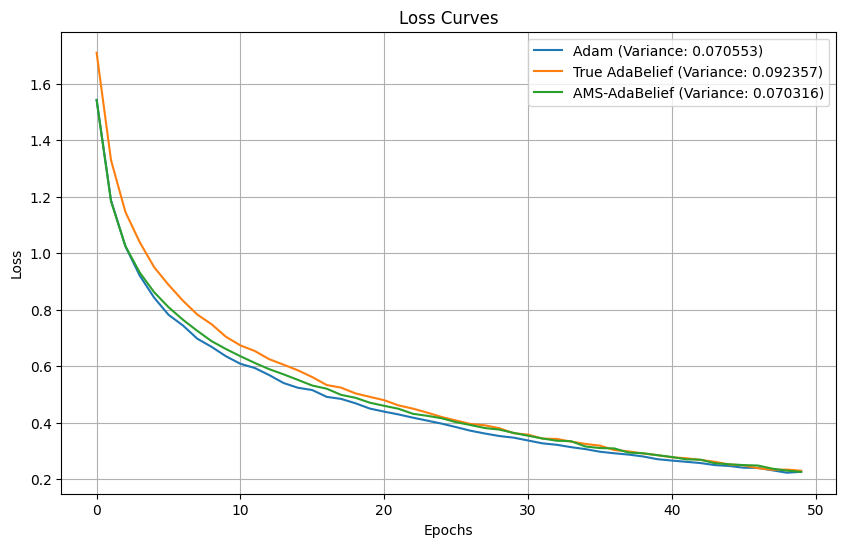

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from adabelief_pytorch import AdaBelief  # True AdaBelief optimizer
import numpy as np
import matplotlib.pyplot as plt

# AMS-AdaBelief Optimizer
class AMSAdaBelief(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-16, weight_decay=0, ams_params=(0.5, 1.0)):
        gamma_min, rho = ams_params
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma_min=gamma_min, rho=rho)
        super(AMSAdaBelief, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                gamma_t = min(1.0, max(group['gamma_min'], group['rho'] * torch.norm(exp_avg) / (torch.norm(exp_avg_sq.sqrt()) + group['eps'])))
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2

                step_size = group['lr'] / (corrected_exp_avg_sq.sqrt().add(group['eps']))
                p.data.add_(-gamma_t * step_size * corrected_exp_avg)
        return loss

# CIFAR-10 Dataset Preparation
def prepare_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader

# Simple ResNet18 Model
def get_model():
    return torchvision.models.resnet18(num_classes=10)

# Training Function
def train(model, optimizer, criterion, trainloader, epochs):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return train_losses

# Testing Function
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Experiment Runner
def run_experiment(optimizer_class, optimizer_name, trainloader, testloader):
    model = get_model().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters())
    print(f"\nTraining with {optimizer_name}...")
    train_losses = train(model, optimizer, criterion, trainloader, epochs=50)
    accuracy = test(model, testloader)
    # Calculate loss stability as variance of training losses
    loss_stability = np.var(train_losses)
    print(f"Loss Stability (Variance): {loss_stability:.6f}")
    return train_losses, accuracy, loss_stability

# Plot Loss Curve
def plot_loss_curves(results):
    plt.figure(figsize=(10, 6))
    for name, res in results.items():
        plt.plot(res["losses"], label=f"{name} (Variance: {res['loss_stability']:.6f})")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves.png")
    plt.show()

# Main Function
if __name__ == "__main__":
    trainloader, testloader = prepare_data()

    # Define optimizers
    optimizers = {
        "Adam": lambda params: optim.Adam(params, lr=1e-3),
        "True AdaBelief": lambda params: AdaBelief(
            params,
            lr=1e-3,
            betas=(0.9, 0.999),
            eps=1e-16,  # Recommended for image classification
            weight_decay=1e-4,
            rectify=True  # Enables rectification for better convergence
        ),
        "AMS-AdaBelief": lambda params: AMSAdaBelief(params, lr=1e-3, ams_params=(0.5, 1.0))
    }

    # Run experiments for each optimizer
    results = {}
    for name, opt_func in optimizers.items():
        train_losses, accuracy, loss_stability = run_experiment(opt_func, name, trainloader, testloader)
        results[name] = {"losses": train_losses, "accuracy": accuracy, "loss_stability": loss_stability}

    # Final Summary
    print("\nFinal Results:")
    for name, res in results.items():
        print(f"{name}: Final Test Accuracy = {res['accuracy']:.2f}%, Loss Stability (Variance) = {res['loss_stability']:.6f}")

    # Plot Loss Curves
    plot_loss_curves(results)


Files already downloaded and verified
Files already downloaded and verified

Training with Adam...
Epoch [1/10], Loss: 2.0116
Epoch [2/10], Loss: 1.6055
Epoch [3/10], Loss: 1.3259
Epoch [4/10], Loss: 1.1372
Epoch [5/10], Loss: 1.0105
Epoch [6/10], Loss: 0.9333
Epoch [7/10], Loss: 0.8642
Epoch [8/10], Loss: 0.8175
Epoch [9/10], Loss: 0.7729
Epoch [10/10], Loss: 0.7510
Test Accuracy: 72.96%
Loss Stability (Variance): 0.153371
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Reco

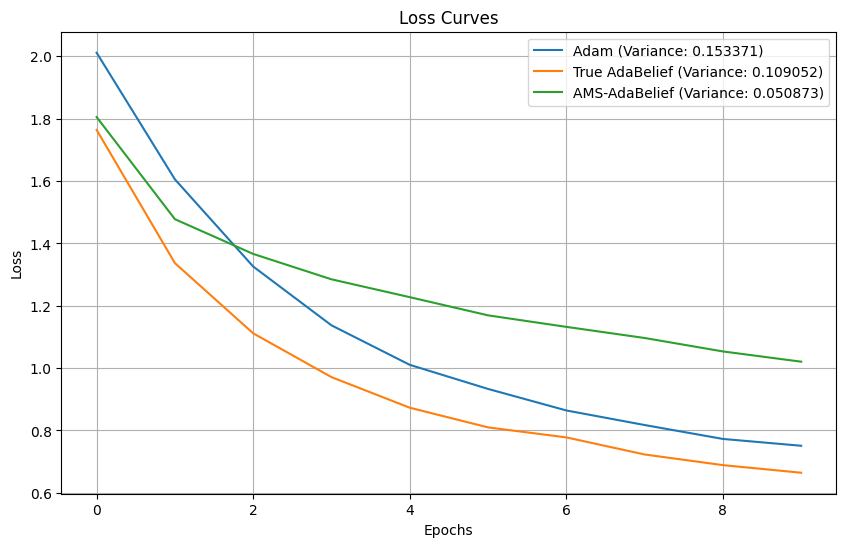

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from adabelief_pytorch import AdaBelief  # True AdaBelief optimizer
import numpy as np
import matplotlib.pyplot as plt

# AMS-AdaBelief Optimizer
class RefinedAMSAdaBelief(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-16, weight_decay=1e-3, ams_params=(0.5, 0.8)):
        gamma_min, rho = ams_params
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma_min=gamma_min, rho=rho)
        super(RefinedAMSAdaBelief, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Smoother Momentum Scaling
                rho = group['rho']
                gamma_min = group['gamma_min']
                gamma_t = min(0.8, max(gamma_min, rho * torch.norm(exp_avg) / (torch.norm(exp_avg_sq.sqrt()) + group['eps'])))

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2

                step_size = group['lr'] / (corrected_exp_avg_sq.sqrt().add(group['eps']))
                p.data.add_(-gamma_t * step_size * corrected_exp_avg)
        return loss



# CIFAR-10 Dataset Preparation
def prepare_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader

# VGG11 Model
def get_model():
    return torchvision.models.vgg11(num_classes=10)

# Training Function
def train(model, optimizer, criterion, trainloader, epochs):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return train_losses

# Testing Function
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Experiment Runner
def run_experiment(optimizer_class, optimizer_name, trainloader, testloader):
    model = get_model().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters())
    print(f"\nTraining with {optimizer_name}...")
    train_losses = train(model, optimizer, criterion, trainloader, epochs=10)
    accuracy = test(model, testloader)
    # Calculate loss stability as variance of training losses
    loss_stability = np.var(train_losses)
    print(f"Loss Stability (Variance): {loss_stability:.6f}")
    return train_losses, accuracy, loss_stability

# Plot Loss Curve
def plot_loss_curves(results):
    plt.figure(figsize=(10, 6))
    for name, res in results.items():
        plt.plot(res["losses"], label=f"{name} (Variance: {res['loss_stability']:.6f})")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves_vgg11.png")
    plt.show()

# Main Function
if __name__ == "__main__":
    trainloader, testloader = prepare_data()

    # Define optimizers
    optimizers = {
        "Adam": lambda params: optim.Adam(params, lr=1e-3),
        "True AdaBelief": lambda params: AdaBelief(
            params,
            lr=1e-3,
            betas=(0.9, 0.999),
            eps=1e-16,  # Recommended for image classification
            weight_decay=1e-4,
            rectify=True  # Enables rectification for better convergence
        ),
        "AMS-AdaBelief": lambda params: RefinedAMSAdaBelief(
            params,
            lr=1e-4,
            weight_decay=1e-3,
            ams_params=(0.2, 0.8)
        )
    }

    # Run experiments for each optimizer
    results = {}
    for name, opt_func in optimizers.items():
        train_losses, accuracy, loss_stability = run_experiment(opt_func, name, trainloader, testloader)
        results[name] = {"losses": train_losses, "accuracy": accuracy, "loss_stability": loss_stability}

    # Final Summary
    print("\nFinal Results:")
    for name, res in results.items():
        print(f"{name}: Final Test Accuracy = {res['accuracy']:.2f}%, Loss Stability (Variance) = {res['loss_stability']:.6f}")

    # Plot Loss Curves
    plot_loss_curves(results)


Files already downloaded and verified
Files already downloaded and verified

Training with Adam...
Epoch [1/50], Loss: 2.0503
Epoch [2/50], Loss: 1.5528
Epoch [3/50], Loss: 1.2633
Epoch [4/50], Loss: 1.0933
Epoch [5/50], Loss: 0.9851
Epoch [6/50], Loss: 0.9060
Epoch [7/50], Loss: 0.8497
Epoch [8/50], Loss: 0.7966
Epoch [9/50], Loss: 0.7655
Epoch [10/50], Loss: 0.7351
Epoch [11/50], Loss: 0.7108
Epoch [12/50], Loss: 0.6852
Epoch [13/50], Loss: 0.6560
Epoch [14/50], Loss: 0.6391
Epoch [15/50], Loss: 0.6344
Epoch [16/50], Loss: 0.6195
Epoch [17/50], Loss: 0.6084
Epoch [18/50], Loss: 0.6147
Epoch [19/50], Loss: 0.6073
Epoch [20/50], Loss: 0.5737
Epoch [21/50], Loss: 0.5737
Epoch [22/50], Loss: 0.5424
Epoch [23/50], Loss: 0.5524
Epoch [24/50], Loss: 0.5365
Epoch [25/50], Loss: 0.5204
Epoch [26/50], Loss: 0.5297
Epoch [27/50], Loss: 0.5084
Epoch [28/50], Loss: 0.5230
Epoch [29/50], Loss: 0.5066
Epoch [30/50], Loss: 0.4943
Epoch [31/50], Loss: 0.5199
Epoch [32/50], Loss: 0.5417
Epoch [33/50],

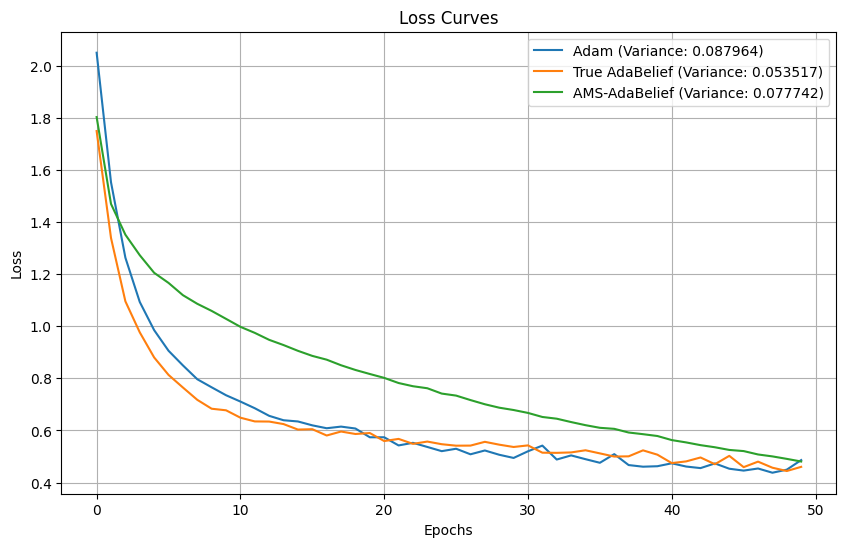

In [ ]:
# AMS-AdaBelief Optimizer
class RefinedAMSAdaBelief(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-16, weight_decay=1e-3, ams_params=(0.5, 0.8)):
        gamma_min, rho = ams_params
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma_min=gamma_min, rho=rho)
        super(RefinedAMSAdaBelief, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Smoother Momentum Scaling
                rho = group['rho']
                gamma_min = group['gamma_min']
                gamma_t = min(0.8, max(gamma_min, rho * torch.norm(exp_avg) / (torch.norm(exp_avg_sq.sqrt()) + group['eps'])))

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2

                step_size = group['lr'] / (corrected_exp_avg_sq.sqrt().add(group['eps']))
                p.data.add_(-gamma_t * step_size * corrected_exp_avg)
        return loss



# CIFAR-10 Dataset Preparation
def prepare_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader

# VGG11 Model
def get_model():
    return torchvision.models.vgg11(num_classes=10)

# Training Function
def train(model, optimizer, criterion, trainloader, epochs):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return train_losses

# Testing Function
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Experiment Runner
def run_experiment(optimizer_class, optimizer_name, trainloader, testloader):
    model = get_model().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters())
    print(f"\nTraining with {optimizer_name}...")
    train_losses = train(model, optimizer, criterion, trainloader, epochs=50)
    accuracy = test(model, testloader)
    # Calculate loss stability as variance of training losses
    loss_stability = np.var(train_losses)
    print(f"Loss Stability (Variance): {loss_stability:.6f}")
    return train_losses, accuracy, loss_stability

# Plot Loss Curve
def plot_loss_curves(results):
    plt.figure(figsize=(10, 6))
    for name, res in results.items():
        plt.plot(res["losses"], label=f"{name} (Variance: {res['loss_stability']:.6f})")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves_vgg11.png")
    plt.show()

# Main Function
if __name__ == "__main__":
    trainloader, testloader = prepare_data()

    # Define optimizers
    optimizers = {
        "Adam": lambda params: optim.Adam(params, lr=1e-3),
        "True AdaBelief": lambda params: AdaBelief(
            params,
            lr=1e-3,
            betas=(0.9, 0.999),
            eps=1e-16,  # Recommended for image classification
            weight_decay=1e-4,
            rectify=True  # Enables rectification for better convergence
        ),
        "AMS-AdaBelief": lambda params: RefinedAMSAdaBelief(
            params,
            lr=1e-4,
            weight_decay=1e-3,
            ams_params=(0.2, 0.8)
        )
    }

    # Run experiments for each optimizer
    results = {}
    for name, opt_func in optimizers.items():
        train_losses, accuracy, loss_stability = run_experiment(opt_func, name, trainloader, testloader)
        results[name] = {"losses": train_losses, "accuracy": accuracy, "loss_stability": loss_stability}

    # Final Summary
    print("\nFinal Results:")
    for name, res in results.items():
        print(f"{name}: Final Test Accuracy = {res['accuracy']:.2f}%, Loss Stability (Variance) = {res['loss_stability']:.6f}")

    # Plot Loss Curves
    plot_loss_curves(results)